<a href="https://colab.research.google.com/github/StephenTGibson/MScDataSci_21-22/blob/main/COMP702-MScProject/Devito_FD_2D_wave_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.devitoproject.org/devito/index.html

In [1]:
# install devito
!pip install devito &> /dev/null

In [2]:
# import libraries and tools
import numpy as np

from time import perf_counter

import matplotlib
import matplotlib.pyplot as plt
# from matplotlib.gridspec import GridSpec

from devito import Grid, TimeFunction, Operator, Constant, Eq, solve, first_derivative, left

from examples.seismic import Model, plot_velocity
from examples.seismic import TimeAxis
from examples.seismic import RickerSource
from examples.seismic import Receiver

In [269]:
extent_x = 2.e3 ### METRES ###
extent_z = 1.e3 ### METRES ###

nx = 401 ### NODES ###
nz = 201 ### NODES ###

absorbingLayer = 10 ### NODES ###

nxTrue = nx + 2*absorbingLayer ### NODES ###
nzTrue = nz + 2*absorbingLayer ### NODES ###

dx = extent_x / (nx-1) ### METRES ###
dz = extent_z / (nz-1) ### METRES ###

shape = (nx, nz)
spacing = (dx, dz)
origin = (0., 0.)

# define medium (acoustic wavespeed)
v = np.empty(shape, dtype=np.float32)
v[:, :] = 2.5 ### KM/S ###
v[:, int(shape[1]/2):] = 1.5  ### KM/S ###

model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=absorbingLayer, bcs="damp")

t0 = 0.  ### MILLISECONDS ###
# dt = 1e-1 ### MILLISECONDS ###
dt = model.critical_dt
T = 2.e3 ### MILLISECONDS ###
nt = T / dt
time_range = TimeAxis(start=t0, stop=T, step=dt)

Operator `initdamp` ran in 0.01 s
INFO:Devito:Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
INFO:Devito:Operator `pad_vp` ran in 0.01 s


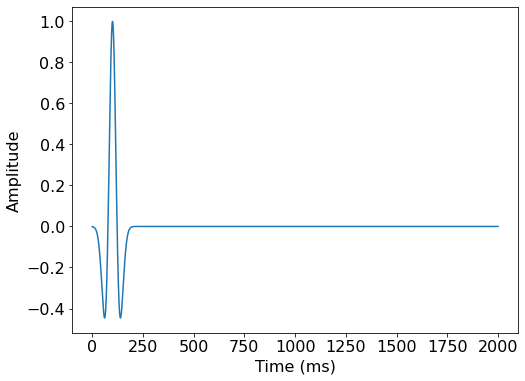

In [270]:
f0 = 0.01 ### kHZ ### # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=1, time_range=time_range)

src.coordinates.data[0, 0] = extent_x*0.5 ### METRES ###
src.coordinates.data[0, 1] = 20. #extent_z*0.5 ### METRES ###

# rec = Receiver(name='rec', grid=model.grid, npoint=101, time_range=time_range)
# rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=101) ### METRES ###
# rec.coordinates.data[:, 1] = 20.  ### METRES ###

# log all intermediate steps
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2, save=int(nt)+2)
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))

src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)
# rec_term = rec.interpolate(expr=u.forward)

op = Operator([stencil] + src_term, subs=model.spacing_map) # + rec_term
# src.show()

In [275]:
# log start time to measure performance
startTime = perf_counter()

# generate solution
summary = op.apply(time=int(nt), dt=dt)

# log end time to measure performance
endTime = perf_counter()
# print total training time
print(f'Training duration: {(endTime-startTime):.2f}s')

# create arrays for plotting
x = np.arange(0, nxTrue*dx, dx)
y = np.arange(0, nzTrue*dz, dz)

Operator `Kernel` ran in 0.25 s
INFO:Devito:Operator `Kernel` ran in 0.25 s


Training duration: 0.26s


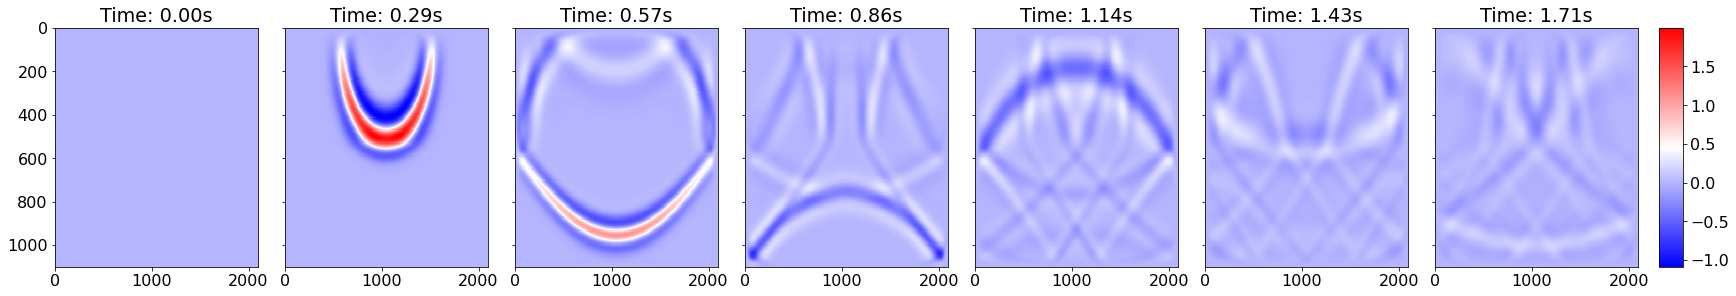

In [293]:
numPlots = 7

fig, axs = plt.subplots(1, numPlots,
                        figsize=(24, 4),
                        constrained_layout=True,
                        sharey=True,
                        )

# create normaliser for colorbar
plotData = np.empty(0)
for num in range(numPlots):
    plotData = np.append(plotData, np.array(u.data[num*int(u.data.shape[0]/numPlots)]))
norm = matplotlib.colors.Normalize(plotData.min(), plotData.max())

cmap = matplotlib.cm.get_cmap('bwr')
mapping = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

for idx, ax in enumerate(axs):
    # print(idx*int(u.data.shape[0]/numPlots) * (T / u.data.shape[0]))
    plot = ax.pcolormesh(x, y, np.array(u.data[idx*int(u.data.shape[0]/numPlots)].T ), norm=norm, cmap='bwr')
    ax.invert_yaxis()
    ax.set_title(f'Time: {1e-3 * idx*int(u.data.shape[0]/numPlots) * (T / u.data.shape[0]):.2f}s')

fig.colorbar(mapping, aspect=60)

plt.show()

In [283]:
T

2000.0

In [288]:
u.data.shape[0]

1634

## Shot record

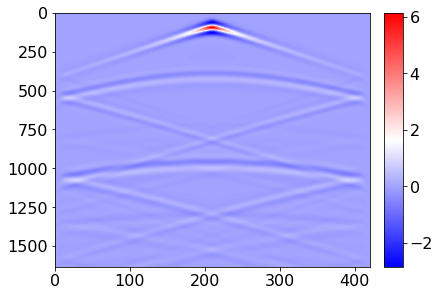

In [273]:
fig, ax = plt.subplots(#1, 5,
                        figsize=(6, 4),
                        constrained_layout=True,
                        # sharey=True,
                        )

# norm = matplotlib.colors.Normalize(results[:,:].min(),results[:,:].max())
# cmap = matplotlib.cm.get_cmap('bwr')
# mapping = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

# for idx, ax in enumerate(axs):
plot = ax.pcolormesh(u.data[:,:,20], cmap='bwr' )#norm=norm, cmap='bwr') # mesh_x, mesh_y,


ax.invert_yaxis()
fig.colorbar(plot)#, ax=axs.ravel(), aspect=60)

plt.show()